In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [29]:
# センサデータ取得
def read_df(path):
    df = pd.read_csv(path)
    return df

# Timeから時間の差を追加
def differ_time(df):
    # Timeから時間の差を割り当てる
    df['dif_sec'] = df['time'].diff().fillna(0)
    df['cum_sec'] = df['dif_sec'].cumsum()
    return df

# 正規化
def act_minxmax_scaler(df):
    scaler = MinMaxScaler()
    scaler.fit(df)
    # 正規化したデータを新規のデータフレームに
    # df_mc = pd.DataFrame(scaler.transform(df), columns=df.columns) 
    # 正規化したデータをnumpyリストに
    mc_list = scaler.fit_transform(df)
    return mc_list

# 部分時系列の作成
def split_part_recurrent_data(data_list, window):
    data_vec = []
    for i in range(len(data_list)-window+1):
        data_vec.append(data_list[i:i+window])
    
    return data_vec

# オートエンコーダの層を作成
def create_auto_encorder(in_out_shape):
    model = Sequential()
    # エンコード
    model.add(Dense(units=200, activation='relu', input_shape=(in_out_shape,)))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=50, activation='relu'))
    # デコード
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=200, activation='relu'))
    # 出力層
    model.add(Dense(in_out_shape, activation='sigmoid'))

    # 作成したネットワークの確認
    model.summary()

    return model

# オートエンコーダ実行
def act_auto_encoder(model, train_vec, batch_size, epochs):
    # 学習条件の設定　誤差関数＝平均二乗誤差、最適化手法＝Adam法
    model.compile(loss='mse', optimizer='adam', metrics=['acc'])

    # 学習の実行
    hist = model.fit(x=train_vec, y=train_vec, batch_size=batch_size, verbose=1, epochs=epochs, validation_split=0.2)

    return hist

# 評価系のグラフをプロット
def plot_evaluation(eval_dict, col1, col2, xlabel, ylabel):
    plt.plot(eval_dict[col1], label=col1)
    plt.plot(eval_dict[col2], label=col2)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    # plt.show()

In [3]:
# データ読み込み
df = read_df('./ecg.csv')
# 使うデータだけ抽出
test_df = df.iloc[:5000, :] 
train_df = df.iloc[5000:, :]

display(test_df.head())
display(train_df.head())

,time,signal1,signal2
0,200.000,4.770,2.100
1,200.004,4.820,2.135
2,200.008,4.805,2.190
3,200.012,4.750,2.285
4,200.016,4.710,2.440


,time,signal1,signal2
5000,220.000,4.965,5.340
5001,220.004,4.950,5.285
5002,220.008,4.945,5.235
5003,220.012,4.930,5.220
5004,220.016,4.930,5.215


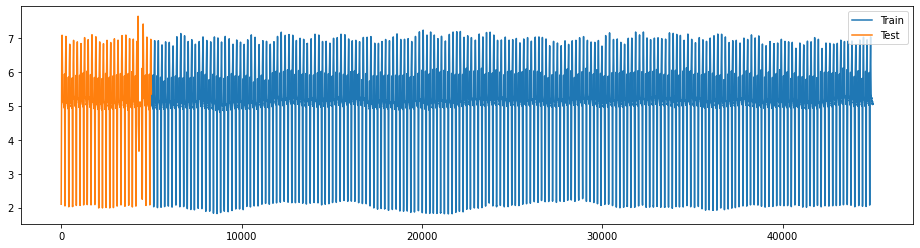

In [23]:
plt.figure(figsize=(16,4))
plt.plot(train_df['signal2'], label='Train')
plt.plot(test_df['signal2'], label='Test')
plt.legend()
# plt.show()
plt.savefig('figure/1_時系列グラフ.png')

In [5]:
test_df = differ_time(test_df) # 秒数を計算 
train_df = differ_time(train_df) # 秒数を計算 

display(test_df)
display(train_df)

,time,signal1,signal2,dif_sec,cum_sec
0,200.000,4.770,2.100,0.000,0.000
1,200.004,4.820,2.135,0.004,0.004
2,200.008,4.805,2.190,0.004,0.008
3,200.012,4.750,2.285,0.004,0.012
4,200.016,4.710,2.440,0.004,0.016
...,...,...,...,...,...
4995,219.980,4.975,5.510,0.004,19.980
4996,219.984,4.995,5.470,0.004,19.984
4997,219.988,4.975,5.430,0.004,19.988
4998,219.992,4.955,5.380,0.004,19.992


,time,signal1,signal2,dif_sec,cum_sec
5000,220.000,4.965,5.340,0.000,0.000
5001,220.004,4.950,5.285,0.004,0.004
5002,220.008,4.945,5.235,0.004,0.008
5003,220.012,4.930,5.220,0.004,0.012
5004,220.016,4.930,5.215,0.004,0.016
...,...,...,...,...,...
44995,379.980,4.860,5.070,0.004,159.980
44996,379.984,4.875,5.070,0.004,159.984
44997,379.988,4.880,5.085,0.004,159.988
44998,379.992,4.870,5.085,0.004,159.992


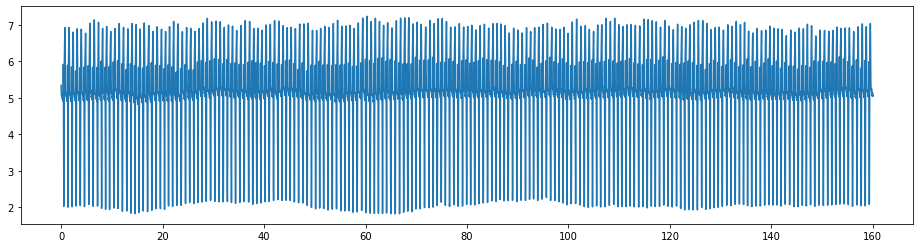

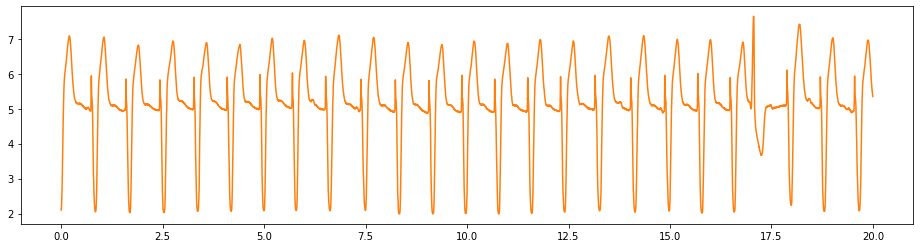

In [6]:
plt.figure(figsize=(16,4))
plt.plot(train_df['cum_sec'], train_df['signal2'], label='Train')
plt.show()

plt.figure(figsize=(16,4))
plt.plot(test_df['cum_sec'], test_df['signal2'], color='tab:orange', label='Test')
plt.show()

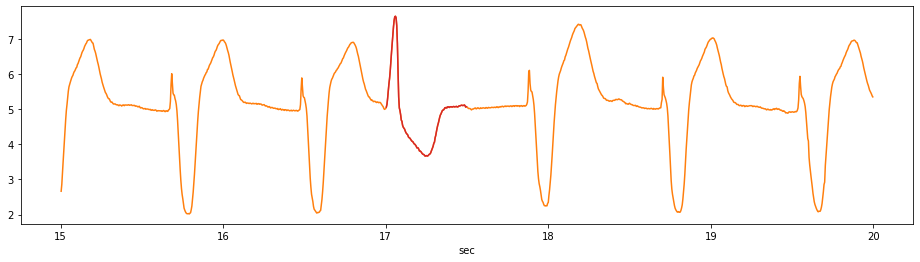

In [26]:
anomaly_df = test_df[(test_df['cum_sec']>15)&(test_df['cum_sec']<20)]
plt.figure(figsize=(16,4))
plt.plot(anomaly_df['cum_sec'], anomaly_df['signal2'], color='tab:orange', label='Test')

anomaly_df = test_df[(test_df['cum_sec']>17)&(test_df['cum_sec']<17.5)] 
plt.plot(anomaly_df['cum_sec'], anomaly_df['signal2'], color='tab:red', label='Test')
plt.xlabel('sec')

# plt.show()
plt.savefig('figure/3_テストデータ時系列グラフ異常定義.png')

In [8]:
test_df.loc[(test_df['cum_sec']>17)&(test_df['cum_sec']<17.5), 'label'] = 1
test_df['label'] = test_df['label'].fillna(0)
test_df[test_df['label']==1]

,time,signal1,signal2,dif_sec,cum_sec,label
4251,217.004,4.605,5.060,0.004,17.004,1.0
4252,217.008,4.560,5.140,0.004,17.008,1.0
4253,217.012,4.530,5.310,0.004,17.012,1.0
4254,217.016,4.545,5.525,0.004,17.016,1.0
4255,217.020,4.565,5.720,0.004,17.020,1.0
...,...,...,...,...,...,...
4370,217.480,4.740,5.110,0.004,17.480,1.0
4371,217.484,4.755,5.120,0.004,17.484,1.0
4372,217.488,4.755,5.100,0.004,17.488,1.0
4373,217.492,4.745,5.060,0.004,17.492,1.0


In [9]:
window = 250

# 正規化
train_vec = act_minxmax_scaler(train_df[['signal2']])
test_vec = act_minxmax_scaler(test_df[['signal2']])

# 一次元リスト
train_vec = train_vec.flatten()
test_vec = test_vec.flatten()

# 部分時系列作成
train_vec = split_part_recurrent_data(train_vec, window)
test_vec = split_part_recurrent_data(test_vec, window)

print(np.array(train_vec).shape)
display(pd.DataFrame(train_vec).head())
print(np.array(test_vec).shape)
display(pd.DataFrame(test_vec).head())

(39751, 250)


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.650369,0.640221,0.630996,0.628229,0.627306,0.625461,0.619004,0.616236,0.615314,0.613469,...,0.607934,0.609779,0.607934,0.605166,0.605166,0.605166,0.607934,0.605166,0.601476,0.604244
1,0.640221,0.630996,0.628229,0.627306,0.625461,0.619004,0.616236,0.615314,0.613469,0.607934,...,0.609779,0.607934,0.605166,0.605166,0.605166,0.607934,0.605166,0.601476,0.604244,0.605166
2,0.630996,0.628229,0.627306,0.625461,0.619004,0.616236,0.615314,0.613469,0.607934,0.608856,...,0.607934,0.605166,0.605166,0.605166,0.607934,0.605166,0.601476,0.604244,0.605166,0.601476
3,0.628229,0.627306,0.625461,0.619004,0.616236,0.615314,0.613469,0.607934,0.608856,0.608856,...,0.605166,0.605166,0.605166,0.607934,0.605166,0.601476,0.604244,0.605166,0.601476,0.598708
4,0.627306,0.625461,0.619004,0.616236,0.615314,0.613469,0.607934,0.608856,0.608856,0.608856,...,0.605166,0.605166,0.607934,0.605166,0.601476,0.604244,0.605166,0.601476,0.598708,0.598708


(4751, 250)


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.019452,0.025641,0.035367,0.052166,0.079576,0.111406,0.144120,0.186561,0.243148,0.301503,...,0.737401,0.748011,0.755084,0.763926,0.768347,0.777188,0.788683,0.796640,0.799293,0.808134
1,0.025641,0.035367,0.052166,0.079576,0.111406,0.144120,0.186561,0.243148,0.301503,0.350133,...,0.748011,0.755084,0.763926,0.768347,0.777188,0.788683,0.796640,0.799293,0.808134,0.811671
2,0.035367,0.052166,0.079576,0.111406,0.144120,0.186561,0.243148,0.301503,0.350133,0.397878,...,0.755084,0.763926,0.768347,0.777188,0.788683,0.796640,0.799293,0.808134,0.811671,0.829355
3,0.052166,0.079576,0.111406,0.144120,0.186561,0.243148,0.301503,0.350133,0.397878,0.449160,...,0.763926,0.768347,0.777188,0.788683,0.796640,0.799293,0.808134,0.811671,0.829355,0.835544
4,0.079576,0.111406,0.144120,0.186561,0.243148,0.301503,0.350133,0.397878,0.449160,0.496905,...,0.768347,0.777188,0.788683,0.796640,0.799293,0.808134,0.811671,0.829355,0.835544,0.841733


In [10]:
in_out_shape = window
# オートエンコーダ作成
model = create_auto_encorder(in_out_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               50200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_5 (Dense)              (None, 250)               50250     
Total params: 150,900
Trainable params: 150,900
Non-trainable params: 0
__________________________________________________

In [11]:
batch_size = 100
epochs = 20

train_vec = np.array(train_vec)
test_vec = np.array(test_vec)
hist = act_auto_encoder(model, train_vec, batch_size, epochs)

Epoch 1/20
318/318 [==============================] - 1s 3ms/step - loss: 0.0090 - acc: 0.0584 - val_loss: 0.0014 - val_acc: 0.1011
Epoch 2/20
318/318 [==============================] - 1s 3ms/step - loss: 0.0011 - acc: 0.1096 - val_loss: 7.4762e-04 - val_acc: 0.0962
Epoch 3/20
318/318 [==============================] - 1s 3ms/step - loss: 6.4285e-04 - acc: 0.1120 - val_loss: 5.4386e-04 - val_acc: 0.0996
Epoch 4/20
318/318 [==============================] - 1s 3ms/step - loss: 5.2786e-04 - acc: 0.1153 - val_loss: 4.9082e-04 - val_acc: 0.1028
Epoch 5/20
318/318 [==============================] - 1s 3ms/step - loss: 4.7851e-04 - acc: 0.1195 - val_loss: 4.2493e-04 - val_acc: 0.1082
Epoch 6/20
318/318 [==============================] - 1s 3ms/step - loss: 4.3090e-04 - acc: 0.1236 - val_loss: 3.7944e-04 - val_acc: 0.1099
Epoch 7/20
318/318 [==============================] - 1s 3ms/step - loss: 4.0277e-04 - acc: 0.1275 - val_loss: 3.7550e-04 - val_acc: 0.1146
Epoch 8/20
318/318 [============

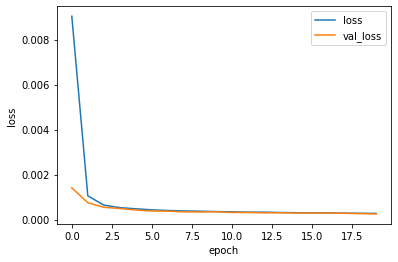

In [30]:
# 誤差の収束具合を描画
# val_lossよりlossが大きければ未学習を疑え
plot_evaluation(hist.history, 'loss', 'val_loss', 'epoch', 'loss')
plt.savefig('figure/4_eval_loss.png')

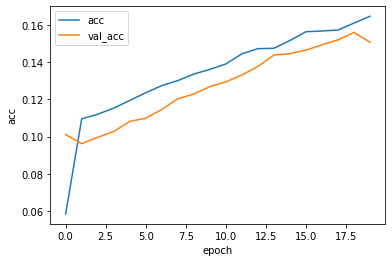

In [31]:
# 評価の収束具合を描画
# val_accよりaccが大きければ過学習を疑え
plot_evaluation(hist.history, 'acc', 'val_acc', 'epoch', 'acc')
plt.savefig('figure/5_eval_acc.png')

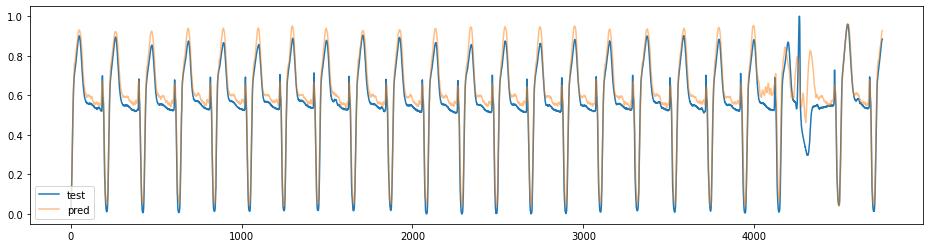

In [32]:
# モデルをテストデータに適用
pred_vec = model.predict(test_vec)

# テストデータと出力データの可視化
plt.figure(figsize=(16,4))
plt.plot(test_vec[:,0], label='test')
plt.plot(pred_vec[:,0], alpha=0.5, label='pred')
plt.legend()
# plt.show()
plt.savefig('figure/6_predict.png')

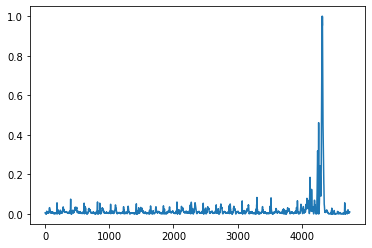

In [33]:
# 予測誤差（異常スコア）の計算
dist = test_vec[:,0] - pred_vec[:,0]
dist = pow(dist, 2)
dist = dist / np.max(dist)

# 異常スコアの可視化
plt.plot(dist)
# plt.show()
plt.savefig('figure/7_dist.png')

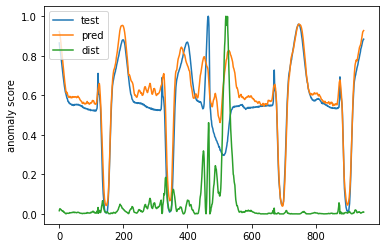

In [52]:
plt.plot(test_vec[3800:,0], label='test')
plt.plot(pred_vec[3800:,0], label='pred')
plt.plot(dist[3800:], label='dist')
plt.legend()
plt.ylabel('anomaly score')
plt.savefig('figure/9_anoamly_socore.png')
# plt.show()

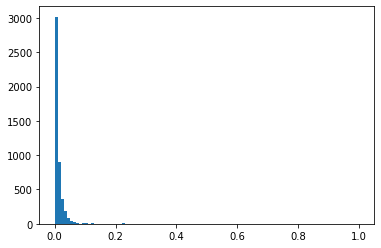

In [53]:
plt.hist(dist, bins=100)
plt.savefig('figure/10_hist.png')
# plt.show()

In [81]:
pred_label_list = [1 if d >= 0.8 else 0 for d in dist]

pred_df = pd.DataFrame(pred_label_list, columns=['pred_label'])

new_test_df = pd.concat([test_df, pred_df], axis=1)
new_test_df = new_test_df.fillna(0)
new_test_df

,time,signal1,signal2,dif_sec,cum_sec,label,pred_label
0,200.000,4.770,2.100,0.000,0.000,0.0,0.0
1,200.004,4.820,2.135,0.004,0.004,0.0,0.0
2,200.008,4.805,2.190,0.004,0.008,0.0,0.0
3,200.012,4.750,2.285,0.004,0.012,0.0,0.0
4,200.016,4.710,2.440,0.004,0.016,0.0,0.0
...,...,...,...,...,...,...,...
4995,219.980,4.975,5.510,0.004,19.980,0.0,0.0
4996,219.984,4.995,5.470,0.004,19.984,0.0,0.0
4997,219.988,4.975,5.430,0.004,19.988,0.0,0.0
4998,219.992,4.955,5.380,0.004,19.992,0.0,0.0


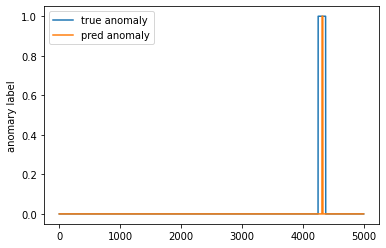

In [82]:
plt.plot(new_test_df['label'], label='true anomaly')
plt.plot(new_test_df['pred_label'], label='pred anomaly')
plt.ylabel('anomary label')
plt.legend()
plt.savefig('figure/8_0.8以上の異常ラベル.png')

In [37]:
print(confusion_matrix(new_test_df['label'], new_test_df['pred_label']))

[[4876    0]
 [ 110   14]]


In [38]:
print('accuracy_score: ', accuracy_score(new_test_df['label'], new_test_df['pred_label']))
print('precision_score: ', precision_score(new_test_df['label'],new_test_df['pred_label']))
print('recall_score: ', recall_score(new_test_df['label'],new_test_df['pred_label']))

accuracy_score:  0.978
precision_score:  1.0
recall_score:  0.11290322580645161


<BarContainer object of 2 artists>

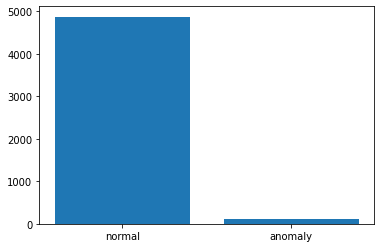

In [21]:
plt.bar(['normal', 'anomaly'], [len(new_test_df[new_test_df['label']==0]), len(new_test_df[new_test_df['label']==1])])

[[4852   24]
 [  46   78]]
accuracy_score:  0.986
precision_score:  0.7647058823529411
recall_score:  0.6290322580645161


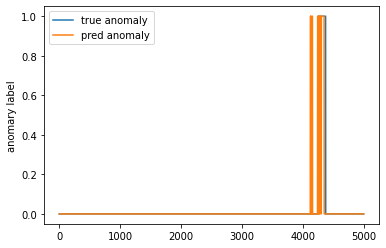

In [79]:
pred_label_list = [1 if d >= 0.1 else 0 for d in dist]

pred_df = pd.DataFrame(pred_label_list, columns=['pred_label'])

new_test_df = pd.concat([test_df, pred_df], axis=1)
new_test_df = new_test_df.fillna(0)

plt.plot(new_test_df['label'], label='true anomaly')
plt.plot(new_test_df['pred_label'], label='pred anomaly')
plt.ylabel('anomary label')
plt.legend()
plt.savefig('figure/11_0.1以上の異常ラベル.png')

print(confusion_matrix(new_test_df['label'], new_test_df['pred_label']))
print('accuracy_score: ', accuracy_score(new_test_df['label'], new_test_df['pred_label']))
print('precision_score: ', precision_score(new_test_df['label'],new_test_df['pred_label']))
print('recall_score: ', recall_score(new_test_df['label'],new_test_df['pred_label']))